## SWE spherical FVM triangular mesh

In [30]:
import pymesh



### Load packages

In [31]:
#pip install trimesh


In [32]:
import trimesh

# Generate a UV sphere
n_stacks = 5  # Number of latitude divisions
n_slices = 10  # Number of longitude divisions
radius = 1.0

# Create the sphere
sphere = trimesh.creation.uv_sphere(radius=radius, count=[n_stacks, n_slices])

# Access vertices and faces
vertices = sphere.vertices
faces = sphere.faces

# Print details
print(f"Number of vertices: {len(vertices)}")
print(f"Number of faces: {len(faces)}")

# Visualize the sphere
#sphere.show()


Number of vertices: 82
Number of faces: 160


In [33]:
vertices.shape
faces.shape

#faces

(160, 3)

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.animation import FuncAnimation
from matplotlib.animation import PillowWriter
import matplotlib.cm as cm
import matplotlib.colors as mcolors 
import matplotlib.tri as mtri
from matplotlib.colors import Normalize


from scipy.io import loadmat
from scipy.optimize import root_scalar


import time

from itertools import product, combinations

### Functions

In [35]:
def randomly_rotate(points):
    """
    Apply a random rotation to a set of 3D points.
    """
    random_rotation_matrix = np.linalg.qr(np.random.randn(3, 3))[0]
    return np.dot(random_rotation_matrix, points)

def get_icosahedral_mesh():
    """
    Generate an icosahedral mesh.
    Returns:
        P (numpy.ndarray): 3x12 array of vertex positions.
        tri (numpy.ndarray): 20x3 array of triangle indices.
    """
    phi = (1 + np.sqrt(5)) / 2
    P = np.array([
        [-1,  phi,  0],
        [ 1,  phi,  0],
        [-1, -phi,  0],
        [ 1, -phi,  0],
        [ 0, -1,  phi],
        [ 0,  1,  phi],
        [ 0, -1, -phi],
        [ 0,  1, -phi],
        [ phi,  0, -1],
        [ phi,  0,  1],
        [-phi,  0, -1],
        [-phi,  0,  1],
    ]).T

    # Normalize vertices to lie on the unit sphere
    P = P / np.linalg.norm(P, axis=0)

    # Center the vertices around the origin
    P = P - np.mean(P, axis=1, keepdims=True)

    # Apply a random rotation
    P = randomly_rotate(P)

    tri = np.array([
        [1, 12, 6],
        [1, 6, 2],
        [1, 2, 8],
        [1, 8, 11],
        [1, 11, 12],
        [2, 6, 10],
        [6, 12, 5],
        [12, 11, 3],
        [11, 8, 7],
        [8, 2, 9],
        [4, 10, 5],
        [4, 5, 3],
        [4, 3, 7],
        [4, 7, 9],
        [4, 9, 10],
        [5, 10, 6],
        [3, 5, 12],
        [7, 3, 11],
        [9, 7, 8],
        [10, 9, 2]
    ]) - 1  # Convert 1-based indexing to 0-based

    return P, tri


def plot_icosahedral_mesh(P, tri):
    """
    Plot an icosahedral mesh using Matplotlib.
    Args:
        P (numpy.ndarray): 3x12 array of vertex positions.
        tri (numpy.ndarray): 20x3 array of triangle indices.
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Create the trisurf plot
    ax.plot_trisurf(P[0, :], P[1, :], P[2, :], triangles=tri, edgecolor='k', linewidth=0.5, alpha=0.8)

    # Set the aspect ratio to be equal
    ax.set_box_aspect([1, 1, 1])  # Equal aspect ratio for all axes

    # Set axis limits for better visualization
    limit = 1.2
    ax.set_xlim([-limit, limit])
    ax.set_ylim([-limit, limit])
    ax.set_zlim([-limit, limit])

    # Turn off the grid and axis for a cleaner look (optional)
    ax.grid(False)
    ax.axis('off')

    plt.show()

def refine_mesh(Pin, triin):
    """
    Refine a triangular mesh by subdividing each triangle into smaller triangles.
    Args:
        Pin (numpy.ndarray): 3xN array of vertex positions.
        triin (numpy.ndarray): Mx3 array of triangle indices.

    Returns:
        P (numpy.ndarray): Refined 3xN array of vertex positions.
        tri (numpy.ndarray): Refined Mx3 array of triangle indices.
    """
    N = Pin.shape[1]  # Number of vertices in the original mesh

    # Step 1: Generate all edges for each triangle
    edges_1 = triin[:, [0, 1]]  # Edges between vertices 0 and 1
    edges_2 = triin[:, [1, 2]]  # Edges between vertices 1 and 2
    edges_3 = triin[:, [2, 0]]  # Edges between vertices 2 and 0

    # Combine all edges and sort each edge to ensure consistent order
    edges = np.vstack([edges_1, edges_2, edges_3])
    edges_sorted = np.sort(edges, axis=1)

    # Step 2: Find unique edges and their indices
    edges_unique, unique_indices = np.unique(edges_sorted, axis=0, return_inverse=True)

    # Step 3: Create new vertices at the midpoints of unique edges
    Pnew = (Pin[:, edges_unique[:, 0]] + Pin[:, edges_unique[:, 1]]) / 2
    Pnew = Pnew / np.linalg.norm(Pnew, axis=0, keepdims=True)  # Normalize to unit sphere

    # Step 4: Map triangle edges to new vertices
    idx1 = unique_indices[:len(triin)]            # Indices for edges_1
    idx2 = unique_indices[len(triin):2*len(triin)]  # Indices for edges_2
    idx3 = unique_indices[2*len(triin):]          # Indices for edges_3

    # Step 5: Generate new triangles
    tri = np.vstack([
        np.column_stack([triin[:, 0], N + idx1, N + idx3]),
        np.column_stack([triin[:, 1], N + idx2, N + idx1]),
        np.column_stack([triin[:, 2], N + idx3, N + idx2]),
        np.column_stack([N + idx1, N + idx2, N + idx3])
    ])

    # Step 6: Combine original and new vertices
    P = np.hstack([Pin, Pnew])

    return P, tri


In [36]:
def compute_EToE(EToV):
    """
    Compute the Element-to-Element (EToE) connectivity for a triangular mesh.
    The EToE[i, j] will give the neighboring element (triangle) for the j-th face of element i.

    Parameters:
        EToV: numpy array of shape (n_elements, 3)
              Each row represents a triangle defined by 3 vertices.

    Returns:
        EToE: numpy array of shape (n_elements, 3)
              EToE[i, j] gives the neighboring triangle index for the j-th face
              of triangle i, or -1 if the face is on the boundary.
    """
    n_elements = EToV.shape[0]
    n_faces = 3  # Triangles have 3 faces

    # Create a dictionary to store edges and their corresponding triangles/faces
    edge_to_element = {}

    # Helper function to sort edges
    def sorted_edge(v1, v2):
        return tuple(sorted((v1, v2)))

    # Populate the edge-to-element mapping
    for elem in range(n_elements):
        for face in range(n_faces):
            # Define the vertices of the current face
            v1, v2 = EToV[elem, face], EToV[elem, (face + 1) % n_faces]
            edge = sorted_edge(v1, v2)

            if edge not in edge_to_element:
                edge_to_element[edge] = []
            edge_to_element[edge].append((elem, face))

    # Initialize the EToE table with -1 (indicating boundary edges)
    EToE = -np.ones((n_elements, n_faces), dtype=int)

    # Populate the EToE table using the edge-to-element mapping
    for edge, connections in edge_to_element.items():
        if len(connections) == 2:
            # If two triangles share the edge, they are neighbors
            (elem1, face1), (elem2, face2) = connections
            EToE[elem1, face1] = elem2
            EToE[elem2, face2] = elem1

    # Rotate the rows of EToE to shift the columns as needed
    EToE = np.roll(EToE, shift=-1, axis=1)
    
    return EToE

### Functions FVM SWE

In [37]:
def spherical_coordinates(x, y, z):
    """
    Convert Cartesian coordinates to spherical coordinates.
    Args:
        x (numpy.ndarray): x-coordinates.
        y (numpy.ndarray): y-coordinates.
        z (numpy.ndarray): z-coordinates.
    Returns:
        r (numpy.ndarray): Radial distance.
        theta (numpy.ndarray): Azimuthal angle.
        phi (numpy.ndarray): Polar angle.
    """
    r = np.sqrt(x**2 + y**2 + z**2)
    theta = np.arctan2(y, x)
    phi = np.arcsin(z / r)    # Latitude
    #phi = np.arccos(z / r)
    return r, theta, phi

def spherical_unit_vectors(x, y, z):
    """
    Compute the spherical unit vectors for given Cartesian coordinates.
    
    Args:
        x, y, z (numpy.ndarray): Cartesian coordinates.
        
    Returns:
        e_theta (numpy.ndarray): Azimuthal unit vector.
        e_phi (numpy.ndarray): Polar unit vector.
    """
    r = np.sqrt(x**2 + y**2 + z**2)
    theta = np.arccos(z / r)
    phi = np.arctan2(y, x)
    
    e_theta = np.array([-np.sin(theta) * np.cos(phi), 
                        -np.sin(theta) * np.sin(phi), 
                        np.cos(theta)])
    
    e_phi = np.array([-np.sin(phi), 
                      np.cos(phi), 
                      0])
    
    return e_theta, e_phi

In [38]:
# Define the global gravity constant
g = 9.81

def FluxX(Q):
    # Initialize F to the same shape as Q
    F = np.zeros_like(Q)

    # Compute the flux in the x-direction    
    F[0, :, :] = Q[1, :, :]
    F[1, :, :] = Q[1, :, :]**2 / Q[0, :, :] + 0.5 * g * Q[0, :, :]**2
    F[2, :, :] = Q[1, :, :] * Q[2, :, :] / Q[0, :, :]

    return F


def FluxY(Q):
    # Initialize G to the same shape as Q
    G = np.zeros_like(Q)

    # Compute the flux in the y-direction
    G[0, :, :] = Q[2, :, :]
    G[1, :, :] = Q[1, :, :] * Q[2, :, :] / Q[0, :, :]
    G[2, :, :] = Q[2, :, :]**2 / Q[0, :, :] + 0.5 * g * Q[0, :, :]**2

    return G


def Lambdax(Q):
    # Initialize L to the same shape as Q
    L = np.zeros_like(Q)

    # Compute velocity and wave speed
    u = Q[1, :, :] / Q[0, :, :]  # u = hu / h
    c = np.sqrt(g * Q[0, :, :])   # c = sqrt(g * h)

    # Characteristic velocities in the x-direction
    L[0, :, :] = u - c
    L[1, :, :] = u
    L[2, :, :] = u + c


    return L

def Lambday(Q):
    # Initialize L to the same shape as Q
    L = np.zeros_like(Q)

    # Compute velocity in y-direction and wave speed
    v = Q[2, :, :] / Q[0, :, :]  # v = hv / h
    c = np.sqrt(g * Q[0, :, :])   # c = sqrt(g * h)

    # Characteristic velocities in the y-direction
    L[0, :, :] = v - c
    L[1, :, :] = v
    L[2, :, :] = v + c

    return L

def minmodarray(a, b):
    nVar, Nx, Ny = a.shape
    c = np.zeros((nVar, Nx, Ny))

    for i in range(nVar):
        # First condition: a * b > 0 and |a| < |b|
        logic1 = (a[i, :, :] * b[i, :, :] > 0) & (np.abs(a[i, :, :]) < np.abs(b[i, :, :]))
        c[i, :, :] = a[i, :, :] * logic1
        
        # Second condition: a * b > 0 and |a| > |b|
        logic2 = (a[i, :, :] * b[i, :, :] > 0) & (np.abs(a[i, :, :]) > np.abs(b[i, :, :]))
        c[i, :, :] += b[i, :, :] * logic2

    return c

def Rusanov(QL, QR, FL, FR, dt, len):
    #smax = np.maximum(np.abs(sL).max(), np.abs(sR).max())
    QL = QL.reshape(3,)
    QR = QR.reshape(3,)
    FL = FL.reshape(3,)
    FR = FR.reshape(3,)
    sL = sL.reshape(3,)
    sR = sR.reshape(3,)
    F = 0.5 * (FR + FL) - 0.5 * len/dt * (QR - QL)
    return F

def spherical_to_cartesian(theta, phi):
    """
    Convert spherical coordinates to Cartesian coordinates.
    Args:
        r (numpy.ndarray): Radial distance.
        theta (numpy.ndarray): Azimuthal angle.
        phi (numpy.ndarray): Polar angle.
    Returns:
        x (numpy.ndarray): x-coordinates.
        y (numpy.ndarray): y-coordinates.
        z (numpy.ndarray): z-coordinates.
    """
    r = 1
    x = r * np.sin(phi) * np.cos(theta)
    y = r * np.sin(phi) * np.sin(theta)
    z = r * np.cos(phi)
    return x, y, z



In [39]:
# Function to rotate a vector outward (90 degrees tangentially on the sphere)
def rotate_vector_outward(normal, edge):
    # Reverse the cross product to point outward
    rotated = -np.cross(normal, edge)
    # Normalize the rotated vector
    norm = np.linalg.norm(rotated)
    return rotated / norm

# Function to compute the midpoint of two points
def compute_midpoint(p1, p2):
    return (p1 + p2) / 2

def face_normal_spherical(EToV, P, i):
    """
    Compute the normal vector for each edge of the triangle in spherical coordinates (theta, phi).
    Args:
        EToV (numpy.ndarray): Element to vertex mapping.
        P (numpy.ndarray): Coordinates of the vertices.
        i (int): Index of the triangle.
    Returns:
        normals (list): List of tuples (theta, phi) for each face (3 per triangle).
    """

    vertices = EToV[i]  # Get the vertex indices for the current triangle
    EToE = compute_EToE(EToV)  # Compute the element-to-element connectivity
    neighbors = EToE[i]
    
    # Get the Cartesian coordinates of the vertices
    x0, y0, z0 = P[:, vertices[0]]
    x1, y1, z1 = P[:, vertices[1]]
    x2, y2, z2 = P[:, vertices[2]]

    # Calculate the edge vectors in Cartesian coordinates
    e0 = np.array([x2 - x1, y2 - y1, z2 - z1])  # Edge 0 (v1, v2)
    e1 = np.array([x0 - x2, y0 - y2, z0 - z2])  # Edge 1 (v2, v0)
    e2 = np.array([x1 - x0, y1 - y0, z1 - z0])  # Edge 2 (v0, v1)
    edges = [e0, e1, e2]

    # Calculate length of the edge vectors in cartesian coordinates
    len_e0 = np.linalg.norm(e0)
    len_e1 = np.linalg.norm(e1)
    len_e2 = np.linalg.norm(e2)
    len_e = [len_e0, len_e1, len_e2]

    # Calculate the edge vectors in spherical coordinates
    _, theta0, phi0 = spherical_coordinates(e0[0], e0[1], e0[2])
    _, theta1, phi1 = spherical_coordinates(e1[0], e1[1], e1[2])
    _, theta2, phi2 = spherical_coordinates(e2[0], e2[1], e2[2])

    # Calculate the edge vectors in spherical coordinates
    sph_e0 = ( (theta1, phi1), (theta2, phi2)) # Edge 0 (v1, v2)
    sph_e1 = ( (theta2, phi2), (theta0, phi0)) # Edge 1 (v2, v0)
    sph_e2 = ( (theta0, phi0), (theta1, phi1)) # Edge 2 (v0, v1)
    sph_edges = [sph_e0, sph_e1, sph_e2]

    # Compute the outward normal of the triangle (cross product of two edges)
    triangle_normal = np.cross(np.array([x2 - x1, y2 - y1, z2 - z1]), np.array([x0 - x1, y0 - y1, z0 - z1]))
    triangle_normal = triangle_normal / np.linalg.norm(triangle_normal)  # Normalize

    # Rotate edges outward by 90 degrees to get the normal vectors of the faces (edges) in cartesian coordinates
    rotated_e0_outward = rotate_vector_outward(triangle_normal, e0)
    rotated_e1_outward = rotate_vector_outward(triangle_normal, e1)
    rotated_e2_outward = rotate_vector_outward(triangle_normal, e2)

    # Normalize the normal vectors
    rotated_e0_outward = rotated_e0_outward / np.linalg.norm(rotated_e0_outward)
    rotated_e1_outward = rotated_e1_outward / np.linalg.norm(rotated_e1_outward)
    rotated_e2_outward = rotated_e2_outward / np.linalg.norm(rotated_e2_outward)

    normals = [rotated_e0_outward, rotated_e1_outward, rotated_e2_outward]

    # Midpoints of edges
    midpoint_e0 = compute_midpoint(np.array([x1, y1, z1]), np.array([x2, y2, z2]))
    midpoint_e1 = compute_midpoint(np.array([x2, y2, z2]), np.array([x0, y0, z0]))
    midpoint_e2 = compute_midpoint(np.array([x0, y0, z0]), np.array([x1, y1, z1]))
    
    # Compute start point of the normal vectors in spherical coordinates
    _, theta0_start, phi0_start = spherical_coordinates(midpoint_e0[0], midpoint_e0[1], midpoint_e0[2])
    _, theta1_start, phi1_start = spherical_coordinates(midpoint_e1[0], midpoint_e1[1], midpoint_e1[2])
    _, theta2_start, phi2_start = spherical_coordinates(midpoint_e2[0], midpoint_e2[1], midpoint_e2[2])

    # Compute end point of the normal vectors in spherical coordinates
    _, theta0_end, phi0_end = spherical_coordinates(rotated_e0_outward[0], rotated_e0_outward[1], rotated_e0_outward[2])
    _, theta1_end, phi1_end = spherical_coordinates(rotated_e1_outward[0], rotated_e1_outward[1], rotated_e1_outward[2])
    _, theta2_end, phi2_end = spherical_coordinates(rotated_e2_outward[0], rotated_e2_outward[1], rotated_e2_outward[2])

    # Compute the normal vectors in spherical coordinates
    sph_normal0 = (theta0_start, phi0_start), (theta0_end, phi0_end)
    sph_normal1 = (theta1_start, phi1_start), (theta1_end, phi1_end)
    sph_normal2 = (theta2_start, phi2_start), (theta2_end, phi2_end)

    sph_normals = [sph_normal0, sph_normal1, sph_normal2]

    return edges, len_e, normals, sph_edges, sph_normals

In [40]:
def plot_icosahedral_water_level(P, tri, Q_all, idx):
    
    # Plot the initial water level
    fig = plt.figure(figsize=(12, 5))
    ax = fig.add_subplot(111, projection='3d')
    #cmap = 'Blues'
    # Create a custom colormap
    cmap = mcolors.LinearSegmentedColormap.from_list('light_blue_to_coolwarm', ['lightblue', 'blue'], N=256)
    collec = ax.plot_trisurf(P[0, :], P[1, :], P[2, :], triangles=tri, cmap=cmap, edgecolor='k', linewidth=0.5, alpha=0.8)
    collec.set_array(Q_all[idx][:, 0])
    collec.autoscale()

    # Add colorbar
    plt.colorbar(collec, ax=ax, shrink=0.5, aspect=5, pad=0.1, label='Water Level (m)')

    # Set title
    ax.set_title('Initial condition: Water level h (m)')

    #ax.set_box_aspect([1, 1, 1])  # Equal aspect ratio for 3D
    ax.set_xlabel('Distance x (m)')
    ax.set_ylabel('Distance y (m)')
    ax.set_zlabel('Distance z (m)')

    plt.show()
    return

def plot_outward_rotated_vectors(P, tri, Q_all, idx):
    EToV = tri
    # Get the vertices of the triangle
    vertices = EToV[idx]
    x0, y0, z0 = P[:, vertices[0]]
    x1, y1, z1 = P[:, vertices[1]]
    x2, y2, z2 = P[:, vertices[2]]

    # Compute the outward rotated vectors for the edges of the triangle
    edges, len_e, normals, sph_edges, sph_normals = face_normal_spherical(EToV, P, idx)
    e0, e1, e2 = edges
    n0, n1, n2 = normals

    # Midpoints of edges
    midpoint_e0 = compute_midpoint(np.array([x1, y1, z1]), np.array([x2, y2, z2]))
    midpoint_e1 = compute_midpoint(np.array([x2, y2, z2]), np.array([x0, y0, z0]))
    midpoint_e2 = compute_midpoint(np.array([x0, y0, z0]), np.array([x1, y1, z1]))
    
    # Plotting
    fig = plt.figure(figsize=(20, 7))
    ax = fig.add_subplot(111, projection='3d')

    # Custom colormap for water level
    cmap = mcolors.LinearSegmentedColormap.from_list('light_blue_to_coolwarm', ['lightblue', 'blue'], N=256)
    collec = ax.plot_trisurf(P[0, :], P[1, :], P[2, :], triangles=tri, cmap=cmap, edgecolor='k', linewidth=0.5, alpha=0.4)
    collec.set_array(Q_all[0][:, 0])
    collec.autoscale()

    # Add colorbar
    plt.colorbar(collec, ax=ax, shrink=0.5, aspect=5, pad=0.1, label='Water Level (m)')

    # Plot outward-rotated vectors from midpoints
    ax.quiver(midpoint_e0[0], midpoint_e0[1], midpoint_e0[2], n0[0], n0[1], n0[2], length=1, color='r', linewidth=2, zorder=15, label='Normal 0')
    ax.quiver(midpoint_e1[0], midpoint_e1[1], midpoint_e1[2], n1[0], n1[1], n1[2], length=1, color='g', linewidth=2, zorder=15, label='Normal 1')
    ax.quiver(midpoint_e2[0], midpoint_e2[1], midpoint_e2[2], n2[0], n2[1], n2[2], length=1, color='b', linewidth=2, zorder=15, label='Normal 2')

    # Set labels and title
    ax.set_title('Outward Rotated Vectors from Edge Midpoints')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()

    plt.show()


def plot_water_level_with_edges(P, tri, Q_all, idx):
    # Get the vertices of the triangle
    EToV = tri
    vertices = EToV[idx]
    x0, y0, z0 = P[:, vertices[0]]
    x1, y1, z1 = P[:, vertices[1]]
    x2, y2, z2 = P[:, vertices[2]]

    # Compute the outward rotated vectors for the edges of the triangle
    edges, len_e, normals, sph_edges, _ = face_normal_spherical(EToV, P, idx)
    e0, e1, e2 = edges

    # Plot the initial water level
    fig = plt.figure(figsize=(20, 7))
    ax = fig.add_subplot(111, projection='3d')

    # Custom colormap
    cmap = mcolors.LinearSegmentedColormap.from_list('light_blue_to_coolwarm', ['lightblue', 'blue'], N=256)
    collec = ax.plot_trisurf(P[0, :], P[1, :], P[2, :], triangles=tri, cmap=cmap, edgecolor='k', linewidth=0.5, alpha=0.8)
    collec.set_array(Q_all[0][:, 0])
    collec.autoscale()

    # Add colorbar
    plt.colorbar(collec, ax=ax, shrink=0.5, aspect=5, pad=0.1, label='Water Level (m)')

    ax.plot(x0, y0, z0,'o', markersize=5, color='r', zorder = 10)
    ax.plot(x1, y1, z1,'o', markersize=5, color='g', zorder = 10)
    ax.plot(x2, y2, z2,'o', markersize=5, color='y', zorder = 10)

    # Plot edges from spherical coordinates
    ax.quiver(x1, y1, z1, e0[0], e0[1], e0[2], length=2, color='r', linewidth=5, zorder = 10)
    ax.quiver(x2, y2, z2, e1[0], e1[1], e1[2], length=2, color='y', linewidth=5, zorder = 10)
    ax.quiver(x0, y0, z0, e2[0], e2[1], e2[2], length=2, color='r', linewidth=5, zorder = 10)

    # Set title and labels
    ax.set_title('Water Level with triangle vertices and edges')
    ax.set_xlabel('X')
    ax.set_ylabel('Y') 
    ax.set_zlabel('Z')

    plt.show()

In [41]:
# Function to calculate surface distance
def surface_distance(point1, point2, radius=1.0):
    theta1, phi1 = point1
    theta2, phi2 = point2
    
    # Central angle
    delta_sigma = np.arccos(
        np.sin(phi1) * np.sin(phi2) +
        np.cos(phi1) * np.cos(phi2) * np.cos(theta2 - theta1)
    )
    
    # Arc length
    return radius * delta_sigma

def surface_distance_components(vector1, vector2, R=1.0):
    """
    Calculate the surface distance components (latitude and longitude) between two points.
    
    Args:
        vector1: [phi, theta] in radians for the first point.
        vector2: [phi, theta] in radians for the second point.
        R: Radius of the sphere (default is 1.0 for unit sphere).
        
    Returns:
        d_phi: Surface distance in the latitude direction.
        d_theta: Surface distance in the longitude direction.
    """
    phi1, theta1 = vector1
    phi2, theta2 = vector2
    
    # Latitude distance
    d_phi = R * abs(phi2 - phi1)
    
    # Longitude distance
    d_theta = R * abs(theta2 - theta1) * np.cos((phi1 + phi2) / 2.0)  # Use midpoint for phi
    
    return d_phi, d_theta


In [42]:
def Lambda_theta(Q):
    # Initalize L to the same shape as Q
    L = np.zeros_like(Q)

    # Compute the characteristic speeds in the theta-direction
    u = Q[:, 1] / Q[:, 0]  # u_theta = hu_theta / h
    c = np.sqrt(g * Q[:, 0])  # c = sqrt(g * h)

    L[:, 0] = u - c
    L[:, 1] = u
    L[:, 2] = u + c

    return L

def Lambda_phi(Q):
    # Initalize L to the same shape as Q
    L = np.zeros_like(Q)

    # Compute the characteristic speeds in the phi-direction
    v = Q[:, 2] / Q[:, 0]  # u_phi = hu_phi / h
    c = np.sqrt(g * Q[:, 0])  # c = sqrt(g * h)

    L[:, 0] = v - c
    L[:, 1] = v
    L[:, 2] = v + c

    return L

def Flux_theta(Q):
    # Initialize F to the same shape as Q
    F = np.zeros_like(Q)

    # Compute the flux in the theta-direction  
    F[:, 0] = Q[:, 1]
    F[:, 1] = Q[:, 1]**2 / Q[:, 0] +  g * Q[:, 0]**2
    F[:, 2] = Q[:, 1] * Q[:, 2] / Q[:, 0]

    return F

def Flux_phi(Q):
    # Initialize G to the same shape as Q
    G = np.zeros_like(Q)

    # Compute the flux in the phi-direction
    G[:, 0] = Q[:, 2]
    G[:, 1] = Q[:, 1] * Q[:, 2] / Q[:, 0]
    G[:, 2] = Q[:, 2]**2 / Q[:, 0] +  g * Q[:, 0]**2
    
    return G

def Rusanov(QL, QR, FL, FR, SL, SR):
    smax = np.maximum(np.abs(SL).max(), np.abs(SR).max())
    QL = QL.reshape(3,)
    QR = QR.reshape(3,)
    FL = FL.reshape(3,)
    FR = FR.reshape(3,)
    SL = SL.reshape(3,)
    SR = SR.reshape(3,)
    F = 0.5 * (FL + FR) - 0.5 * smax * (QR - QL)
    return F

# Calculate the initial total volume
def compute_total_volume(Q, EToV, P):
    total_volume = 0.0
    N_triangles = EToV.shape[0]
    for i in range(N_triangles):
        vertices = EToV[i]
        x0, y0, z0 = P[:, vertices[0]]
        x1, y1, z1 = P[:, vertices[1]]
        x2, y2, z2 = P[:, vertices[2]]
        
        # Calculate the area of the triangle
        triangle_area = 0.5 * np.linalg.norm(np.cross([x1 - x0, y1 - y0, z1 - z0], [x2 - x0, y2 - y0, z2 - z0]))
        
        # Add to total volume: h0 * area of the triangle
        total_volume += Q[i, 0] * triangle_area
    return total_volume


## Icosahedral

P shape: (3, 12), tri shape: (20, 3)
P shape: (3, 42), tri shape: (80, 3)
P shape: (3, 162), tri shape: (320, 3)


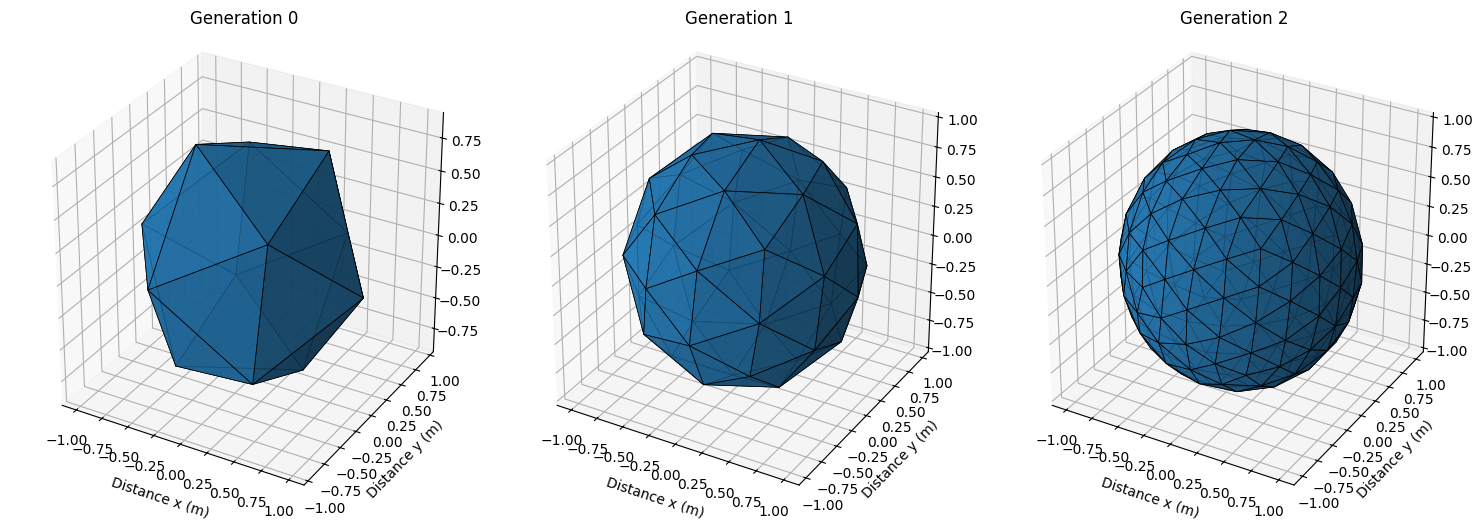

In [43]:
# Generate the initial icosahedral mesh
P, tri = get_icosahedral_mesh()

# Prepare for refinement generations
generations = 3
meshes = [(P, tri)]  # Store the meshes for each generation

# Generate refined meshes for each generation
for _ in range(generations):
    print(f'P shape: {P.shape}, tri shape: {tri.shape}')
    P, tri = refine_mesh(P, tri)
    meshes.append((P, tri))

# Create subplots to visualize the first three generations
fig = plt.figure(figsize=(15, 5))
for i in range(generations):
    ax = fig.add_subplot(1, generations, i + 1, projection='3d')
    P, tri = meshes[i]
    ax.plot_trisurf(
        P[0, :], P[1, :], P[2, :],
        triangles=tri,
        edgecolor='k',
        linewidth=0.5,
        alpha=0.8
    )
    ax.set_title(f"Generation {i}")
    ax.set_box_aspect([1, 1, 1])  # Equal aspect ratio for 3D
    ax.set_xlabel('Distance x (m)')
    ax.set_ylabel('Distance y (m)')
   # ax.axis('off')  # Turn off axis for clarity

# Display the subplots
plt.tight_layout()
#plt.savefig('Plots/icosahedral_mesh_refinement.pdf', format='pdf')
plt.show()

In [44]:
def compute_phi_midpoint(x1, y1, z1, x2, y2, z2):
    """Compute the phi (latitude) component of the midpoint of two Cartesian points."""
    # Midpoint in Cartesian coordinates
    x_mid = (x1 + x2) / 2
    y_mid = (y1 + y2) / 2
    z_mid = (z1 + z2) / 2

    # Radius of the sphere
    r_mid = np.sqrt(x_mid**2 + y_mid**2 + z_mid**2)
    r_mid = 1

    # Compute phi (latitude), in radians
    phi_mid = np.arccos(z_mid / r_mid)
    return phi_mid


def compute_phi_centroid(x0, y0, z0, x1, y1, z1, x2, y2, z2):
    """Compute the phi (latitude) of the centroid of a triangle given its vertices in Cartesian coordinates."""
    # Compute the centroid in Cartesian coordinates
    x_centroid = (x0 + x1 + x2) / 3
    y_centroid = (y0 + y1 + y2) / 3
    z_centroid = (z0 + z1 + z2) / 3

    # Radius of the sphere at the centroid
    r_centroid = np.sqrt(x_centroid**2 + y_centroid**2 + z_centroid**2)

    # Compute phi (latitude), in radians
    phi_centroid = np.arcsin(z_centroid / r_centroid)
    return phi_centroid


In [ ]:
EToV = tri
N_triangles = EToV.shape[0]

# Initialize
Q = np.zeros((N_triangles, 3))
# Set initial overall water level to 1 m
Q[:, 0] = 1
Q.shape

EToV = tri
EToE = compute_EToE(EToV)
# Define inital water level
h0 = 2

# Triangle with initial high water level
idx = 0
print(f'Triangle: {idx} with neighbors: {EToE[idx]}')
# Set initial water level for idx and the surrounding triangles
Q[idx, 0] = h0
for j in range(3):
    neighbor = EToE[idx, j]
    Q[neighbor, 0] = h0

t = 0
tend = 0.001  # End time
dt = 0.001 # Time step
CFL = 0.9

# Initialize lists for storing the water levels and time steps
Q_all = [Q]
t_all = [t]
total_volume_initial = compute_total_volume(Q, EToV, P) # Initial total volume
print(f'Initial total volume: {total_volume_initial:.4f} m^3')

Qnew = np.copy(Q)

# Start timer
start_time = time.time()

# Time loop
while t < tend:
    print(f't = {t:.4f}')
    if t + dt > tend:
        dt = tend - t

    # Compute the fluxes
    F, G = Flux_theta(Q), Flux_phi(Q)

    # Compute the characteristic speeds
    L_theta, L_phi = Lambda_theta(Q), Lambda_phi(Q)

    # Loop through each triangle
    for i in range(N_triangles):
        # Extract element data
        vertices = EToV[i]
        neighbors = EToE[i]
        #print(f'Element: {i} with neighbors: {neighbors}')

        # Compute the normal vectors for the current face
        edges, len_e, normals, sph_edges, sph_normals  = face_normal_spherical(EToV, P, i)
        # Calculate lengths for all edges
        edge_lengths = [surface_distance(edge[0], edge[1], 1) for edge in sph_edges]
        #edge_lengths = np.linalg.norm(edges, axis=1)
        
        # Get cartesian coordinates of the vertices
        x0, y0, z0 = P[:, vertices[0]]
        x1, y1, z1 = P[:, vertices[1]]
        x2, y2, z2 = P[:, vertices[2]]

        # Compute the phi component at the centroid of the triangle
        phi_centroid = compute_phi_centroid(x0, y0, z0, x1, y1, z1, x2, y2, z2)

        # Compute the phi component of midpoints for each edge
        phi_midpoint01 = compute_phi_midpoint(x0, y0, z0, x1, y1, z1)
        phi_midpoint12 = compute_phi_midpoint(x1, y1, z1, x2, y2, z2)
        phi_midpoint20 = compute_phi_midpoint(x2, y2, z2, x0, y0, z0)

        # Midpoints in spherical latitude
        phi_midpoints = [phi_midpoint12, phi_midpoint20, phi_midpoint01]

        # Compute fluxes
        fluxes = []
        for f in range(3): # Loop through each face
            neighbor = EToE[i, f]

            # Calculate phi-component of the edge
            phi = phi_midpoints[f]    

            # Numerical fluxes in theta-direction
            F_t = Rusanov(Q[i], Q[neighbor], F[i], F[neighbor], L_theta[i], L_theta[neighbor])
            
            # Numerical fluxes in phi-direction
            G_t = Rusanov(Q[i], Q[neighbor], G[i], G[neighbor], L_phi[i], L_phi[neighbor])

            # Collect the fluxes in one array
            fluxes_t = np.array([F_t, G_t])

            # Correct the fluxes with the normal vectors
            temp = surface_distance_components(sph_normals[f][0], sph_normals[f][1])
            temp /= np.linalg.norm(temp)
            flux_normal = np.dot(temp, fluxes_t)

            # Store the corrected fluxes
            fluxes.append(flux_normal)
            #print(f'Fluxes: {fluxes}')

        # Update Qnew for triangle i
        Qnew[i] = Q[i] - dt *sum(edge_lengths[f]* fluxes[f] for f in range(3)) # Subtract the sum of the fluxes for each face 
        
    # Update Q and time
    t += dt
    Qnew[:, 0] = np.maximum(1e-10, Qnew[:, 0])
    Q = np.copy(Qnew)

    total_volume_current = compute_total_volume(Q, EToV, P)
    print(f'Total volume: {total_volume_current:.4f} m^3')
    volume_difference = total_volume_current - total_volume_initial
    if volume_difference != 0:
        correction_factor = total_volume_initial / total_volume_current
        #Q[:, 0] *= correction_factor  # Scale water levels to conserve volume

    # Store the water levels and time steps
    Q_all.append(Q)
    t_all.append(t)

n = len(Q_all)
print(f'Number of time steps: {n}')

# Stop timer and print elapsed time
end_time = time.time()
print(f'Time elapsed: {end_time - start_time:.4f} seconds')


Triangle: 0 with neighbors: [240   1   4]
Initial total volume: 12.4759 m^3
t = 0.0000
Element: 0 with neighbors: [240   1   4]
Fluxes: [array([ 0.        , 37.87085043, 10.27503225])]
Fluxes: [array([ 0.        , 37.87085043, 10.27503225]), array([ 0.        , 38.11741639,  9.31880722])]
Fluxes: [array([ 0.        , 37.87085043, 10.27503225]), array([ 0.        , 38.11741639,  9.31880722]), array([  0.        ,   2.24129735, -39.17593887])]
Element: 1 with neighbors: [241   2   0]
Fluxes: [array([ 2.54295174, 24.20386787,  3.95580648])]
Fluxes: [array([ 2.54295174, 24.20386787,  3.95580648]), array([ -2.19363874,   0.23238315, -24.52389902])]
Fluxes: [array([ 2.54295174, 24.20386787,  3.95580648]), array([ -2.19363874,   0.23238315, -24.52389902]), array([ 0.        , 38.89726521, -5.17497434])]
Total volume: 12.4759 m^3
Number of time steps: 2
Time elapsed: 0.0227 seconds


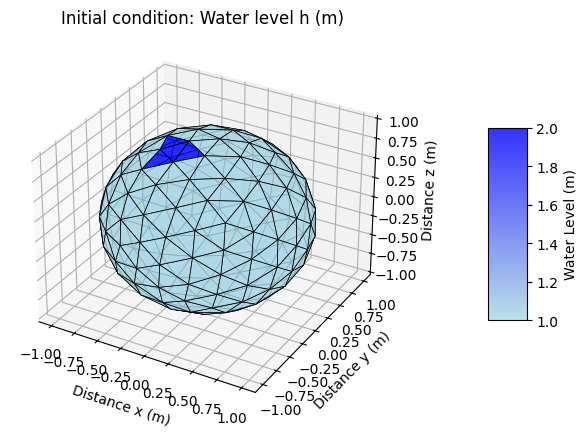

In [46]:
plot_icosahedral_water_level(P, tri, Q_all, 0)

In [47]:
Q_all[0][:5], Q_all[1][:5], Q_all[-1][:5]

(array([[2., 0., 0.],
        [2., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [2., 0., 0.]]),
 array([[ 2.        , -0.16038349,  0.045942  ],
        [ 1.99998027, -0.1317381 ,  0.0575941 ],
        [ 1.00512163, -0.09069158,  0.00295707],
        [ 1.00514402, -0.07534941,  0.01241425],
        [ 1.99032149, -0.18381275, -0.02219323]]),
 array([[ 2.        , -0.16038349,  0.045942  ],
        [ 1.99998027, -0.1317381 ,  0.0575941 ],
        [ 1.00512163, -0.09069158,  0.00295707],
        [ 1.00514402, -0.07534941,  0.01241425],
        [ 1.99032149, -0.18381275, -0.02219323]]))

### Plot in cartesian coordinates

In [48]:
vertices = EToV[idx]
x0, y0, z0 = P[:, vertices[0]]
x1, y1, z1 = P[:, vertices[1]]
x2, y2, z2 = P[:, vertices[2]]

# Compute the outward rotated vectors for the edges of the triangle
edges, len_e, normals, sph_edges, sph_normals = face_normal_spherical(EToV, P, idx)
e0, e1, e2 = edges
n0, n1, n2 = normals

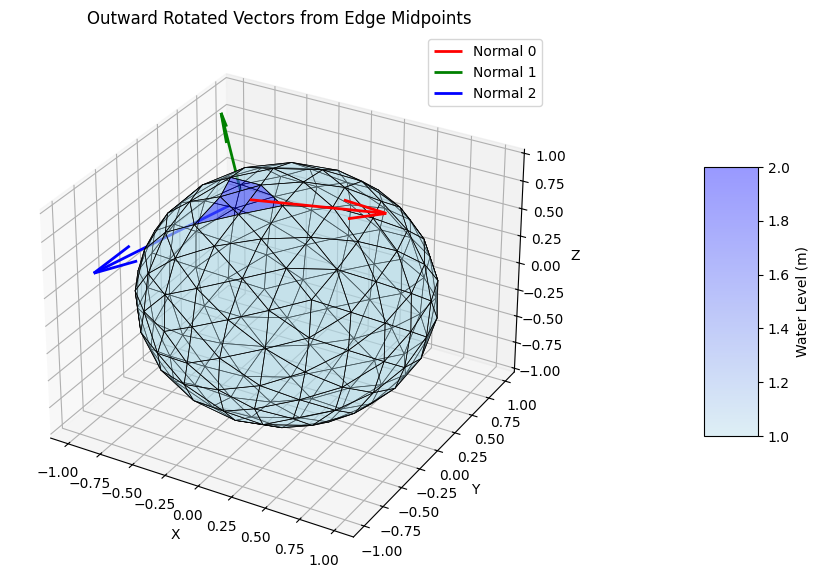

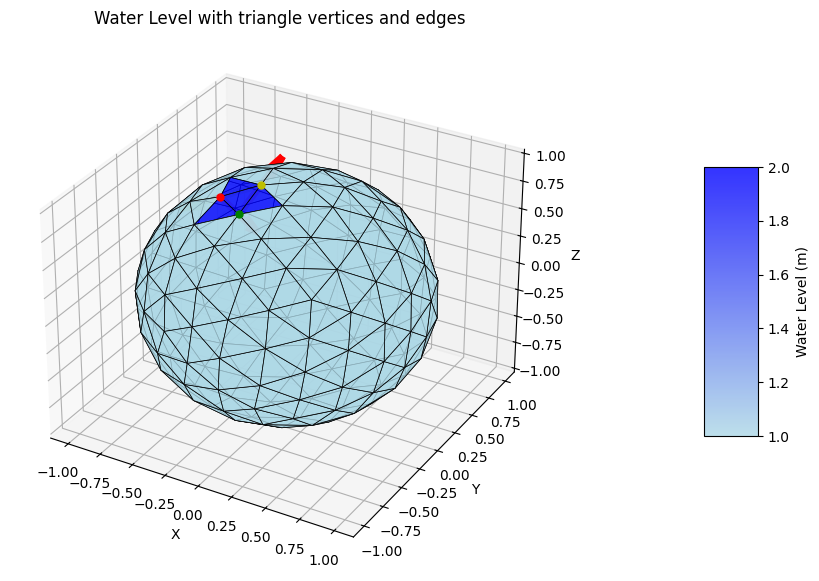

In [49]:
plot_outward_rotated_vectors(P, tri, Q_all, idx)
plot_water_level_with_edges(P, tri, Q_all, idx)

### Plot in spherical coordinates

In [50]:
vertices = EToV[idx]
x0, y0, z0 = P[:, vertices[0]]
x1, y1, z1 = P[:, vertices[1]]
x2, y2, z2 = P[:, vertices[2]]

# Triangle vertices in spherical coordinates
_, theta0, phi0 = spherical_coordinates(x0, y0, z0)
_, theta1, phi1 = spherical_coordinates(x1, y1, z1)
_, theta2, phi2 = spherical_coordinates(x2, y2, z2)

# Compute the outward rotated vectors for the edges of the triangle
edges, len_e, normals, sph_edges, sph_normals = face_normal_spherical(EToV, P, idx)
e0, e1, e2 = edges
n0, n1, n2 = normals
sph0, sph1, sph2 = sph_edges


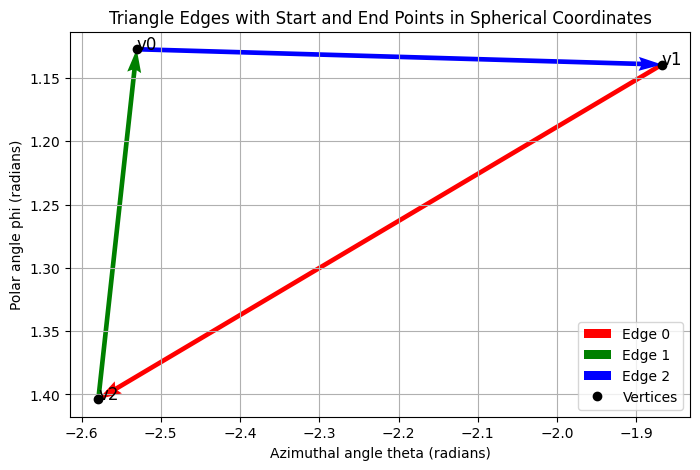

In [51]:
# Plotting
fig, ax = plt.subplots(figsize=(8, 5))

# Plot the edges as quivers
ax.quiver(theta1, phi1, theta2-theta1, phi2-phi1, color='r', angles='xy', scale_units='xy', scale=1, label='Edge 0')
ax.quiver(theta2, phi2, theta0-theta2, phi0-phi2, color='g', angles='xy', scale_units='xy', scale=1, label='Edge 1')
ax.quiver(theta0, phi0, theta1-theta0, phi1-phi0, color='b', angles='xy', scale_units='xy', scale=1, label='Edge 2')

# Mark the vertices
ax.plot([theta0, theta1, theta2], [phi0, phi1, phi2], 'ko', label='Vertices')

# Add labels for clarity
ax.text(theta0, phi0, 'v0', fontsize=12)
ax.text(theta1, phi1, 'v1', fontsize=12)
ax.text(theta2, phi2, 'v2', fontsize=12)

# Configure plot
ax.set_xlabel('Azimuthal angle theta (radians)')
ax.set_ylabel('Polar angle phi (radians)')
ax.set_title('Triangle Edges with Start and End Points in Spherical Coordinates')
ax.legend()
ax.grid()
ax.invert_yaxis()  # Invert phi-axis for conventional latitude representation
plt.show()
